In [1]:
# from https://chrishavlin.com/2019/08/20/shapefiles-in-python-converting-contours-to-shapes/

In [5]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os,json           # json just a convenient way to dump some numbers (contour levels)
from descartes.patch import PolygonPatch

from glob import glob
import xarray as xr
import dask.array as da

In [6]:
!ls

Coast_tagging_makePWhistogram.ipynb
Coast_tagging_old.ipynb
Extract_WEIO_from_MERRA2.ipynb
LICENSE
MERRA2_400.inst1_2d_asm_Nx.20140515.SUB.nc
README.md
TQV_contours_shapefiles.ipynb
TQV_fcontours_shapefiles.ipynb
Track_Lakes_Backward.ipynb
Track_Lakes_Backward_earliest_version.ipynb
Whiteboard[2].pdf
contourf_to_shp.py
landmask_MERRA2.nc
test_shaped_contour


In [102]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

lon = cwv_data.lon
lat = cwv_data.lat
tqv = cwv_data.TQV[0].values

<Figure size 720x360 with 0 Axes>

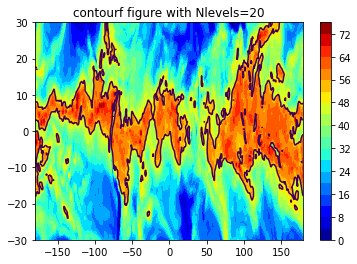

In [147]:
plt.figure(figsize=[10,5])
fig, ax = plt.subplots()

Nlevels=20
cs = plt.contourf(lon,lat,tqv,Nlevels,cmap='jet')
ax.contour(lon,lat,tqv,[50])
plt.title('contourf figure with Nlevels='+str(Nlevels))
plt.colorbar()

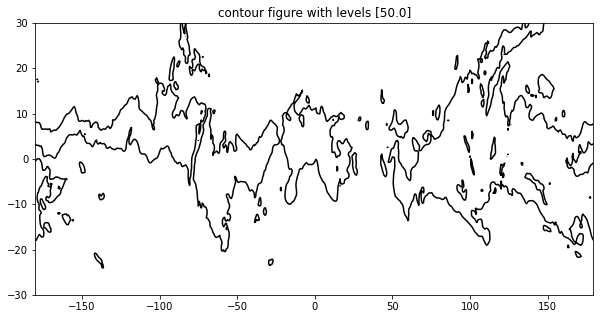

In [148]:
# make the contourf plot, storing the resulting ContourSet in cs
plt.figure(figsize=[10,5])
# Nlevels=3
levels = [ 30., 40., 50., 60.]
levels = [50.]
cs = plt.contour(lon,lat,tqv,levels,cmap='gist_heat')
plt.title('contour figure with levels '+ str(levels))

# create lookup table for levels
lvl_lookup = dict(zip(cs.collections, cs.levels))

In [136]:
# loop over collections (and polygons in each collection), store in list for fiona
PolyList=[]
for col in cs.collections:
    z=lvl_lookup[col] # the value of this level
    for contour_path in col.get_paths():
        # create the polygon for this level
        for ncp,cp in enumerate(contour_path.to_polygons()):
            lons = np.array(cp)[:,0]
            lats = np.array(cp)[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
            if ncp == 0:
                poly = new_shape # first shape
            else:
                poly = poly.difference(new_shape) # Remove the holes
        PolyList.append({'poly':poly,'props':{'z': z}})
        

In [137]:
## write the fiona collection

# clean up directories
outname=os.path.join('.','test_shaped_contour')
if os.path.isdir(outname):
    for file in os.listdir(outname):
        os.remove(os.path.join(outname,file))
    os.rmdir(outname)
os.mkdir(outname)

# define ESRI schema, write each polygon to the file
outfi=os.path.join(outname,'shaped_contour.shp')
schema = {'geometry': 'Polygon','properties': {'z': 'float'}}
with fiona.collection(outfi, "w", "ESRI Shapefile", schema) as output:
    for p in PolyList:
        output.write({'properties': p['props'],
            'geometry': geometry.mapping(p['poly'])})

<Figure size 1080x360 with 0 Axes>

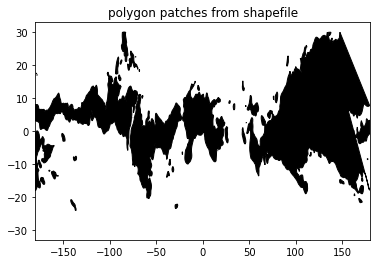

In [139]:
## Plotting the results: reads data back in, plots the polygons 

plt.figure(figsize=[15,5])
fig, ax = plt.subplots()

cmap=plt.cm.gist_heat
lv_min = min(levels)
lv_range=max(levels)-min(levels)+10

# loop over each shape, pull out level value ('z'), plot a polygon 

ishp=0
with fiona.open(outfi) as shape:
    for shp in shape:

        # pull this shape's level 
        lv=shp['properties']['z'] # this shape's level
        clr=cmap((lv - lv_min)/(lv_range))

        # build the polygon and add the patch
        coords=shp['geometry']['coordinates'][0] # coords of this polygon
        poly=geometry.Polygon(coords)
        patch = PolygonPatch(poly, facecolor=clr, edgecolor=clr)
        ax.add_patch(patch)
        
        # track max/min coordinate values
        bnds=poly.bounds
        rng_C={'lon':{'min':bnds[0],'max':bnds[2]},
               'lat':{'min':bnds[1],'max':bnds[3]}}
        if ishp==0:
            rngs=rng_C
        else:
            for ll in ['lon','lat']:
                rngs[ll]['max']=max([rngs[ll]['max'],rng_C[ll]['max']])
                rngs[ll]['min']=min([rngs[ll]['min'],rng_C[ll]['min']])
        
        ishp=ishp+1

ax.set_xlim([-180,180])
ax.set_ylim([-33,33])
plt.title('polygon patches from shapefile')
plt.show()

In [ ]:
# Better plotting of multiple shapes: geopandas
# https://geopandas.org/gallery/overlays.html
    